In [4]:
#add tf.float as variable 
#simply as much as you can

In [5]:
!pip install pyDOE
#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
# sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

#import GaussJacobiQuadRule_V3


import tensorflow as tf
print(tf.version)
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

2023-09-18 20:39:37.309748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 20:39:37.331998: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 20:39:37.536027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 20:39:37.538069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 20:39:38.401284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<module 'tensorflow._api.v2.version' from '/home/mariano/Documenti/test/base/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [6]:
class parameters:
    def __init__(self,LR,Opt_Niter,N_Element,N_testfcn,N_Quad,lossb_weight,a,b):
        self.LR = LR
        self.Opt_Niter = Opt_Niter + 1
        self.Opt_tresh = 2e-32
        self.var_form=2
        self.N_Element = N_Element
        self.N_testfcn = N_testfcn #number of test function
        self.N_Quad = N_Quad    #quadrature points 
        self.lossb_weight = lossb_weight #hyprparameter we may turn it up

        #params for the exact sol and boundary term
        self.omega = 8*np.pi
        self.amp = 1
        self.r1 = 80

        #ingredients for loss
        [self.x_quad, self.w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)
        

        self.test_quad_element = self.Test_fcn(self.N_testfcn, self.x_quad)
        self.d1test_quad_element, self.d2test_quad_element = self.dTest_fcn(self.N_testfcn, self.x_quad)


        [self.x_l, self.x_r] = [a, b]     #modify in the future if you want general (a,b) interval
        self.delta_x = (self.x_r - self.x_l)/N_Element
        self.grid = np.asarray([ self.x_l + i*self.delta_x for i in range(self.N_Element+1)])

        #build right side (it doesnt depend on the network)

        self.F_ext_total = []
        for e in range(self.N_Element):
            x_quad_element = self.grid[e] + (self.grid[e+1]-self.grid[e])/2*(self.x_quad+1)  #traslation of the element 

            jacobian = (self.grid[e+1]-self.grid[e])/2
            testfcn_element = np.asarray([ self.Test_f(n,self.x_quad)  for n in range(1, self.N_testfcn+1)])

            #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )

            f_quad_element = self.f_ext(x_quad_element)
            F_ext_element  = jacobian*np.asarray([sum(self.w_quad*f_quad_element*testfcn_element[i]) for i in range(self.N_testfcn)])    
            F_ext_element = F_ext_element[:,None] 
            self.F_ext_total.append(F_ext_element)

        self.F_ext_total = np.asarray(self.F_ext_total)


        self.X_bound = np.asarray([a,b],dtype=np.float64)[:,None]
        self.u_bound   = self.u_exact(self.X_bound)

    def u_exact(self,x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r1*x)
        return self.amp*utemp

    def f_ext(self,x):
        gtemp =  -0.1*(self.omega**2)*np.sin(self.omega*x) - (2*self.r1**2)*(np.tanh(self.r1*x))/((np.cosh(self.r1*x))**2)
        return -self.amp*gtemp

    def Test_f(self,n,x):
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        return test
    
    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

In [7]:
params=parameters(0.01,1000,5,20,100,1,-1,1)

/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


In [34]:
class Model(tf.keras.Model):
  def __init__(self,*kwargs):
    super().__init__()
    #structure of the nework maybe implment a general way
    self.dense1 = tf.keras.layers.Dense(units=16,
                                        activation='relu',
                                        kernel_initializer=tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.HeNormal())
    self.dense2 = tf.keras.layers.Dense(units=16,
                                    activation='relu',
                                    kernel_initializer=tf.keras.initializers.HeNormal(),
                                    bias_initializer=tf.keras.initializers.HeNormal())
    self.y = tf.keras.layers.Dense(1)
    self.history=[]
    self.params=params
    

  def call(self,input):
    x=self.dense1(input)
    x=self.dense2(x)
    return self.y(x)


  @tf.function
  def net_du(self, x):
    with tf.GradientTape() as g:
      g.watch(x)
      with tf.GradientTape() as gg:
        gg.watch(x)
        y = model(x)
      dy_dx = gg.gradient(y, x)  # dy_dx = 2 * x
    
    d2y_dx2 = g.gradient(dy_dx, x)  # d2y_dx2 = 2
    return dy_dx,d2y_dx2

  def train(self):
    variables = self.trainable_variables
    optimizer = tf.optimizers.Adam(learning_rate=self.params.LR)
    print('-->training_starting')
    for step in range(self.params.Opt_Niter):
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(variables)
        loss =self.calculate_loss()
        
      gradient = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(gradient, variables))

      if step % 10 == 0:
        print(f'Iter: {step}',f'loss: {loss.numpy():0.6f}')
        self.history.append(loss)
        
  @tf.function    
  def calculate_loss(self):
    varloss_total = 0
    
    for e in range(self.params.N_Element):
        F_ext_element  = self.params.F_ext_total[e]
        Ntest_element  = np.shape(F_ext_element)[0] #for each you have N_testfcn
        x_quad_element = tf.cast((self.params.grid[e] + (self.params.grid[e+1]-self.params.grid[e])/2*(self.params.x_quad+1)),tf.float32)
        x_b_element    = tf.cast(np.array([[self.params.grid[e]], [self.params.grid[e+1]]]),tf.float32)
        #to change change integral to the ref segment in (-1,1)
        jacobian       = (self.params.grid[e+1]-self.params.grid[e])/2

        u_NN_quad_element = model(x_quad_element)
        
        d1u_NN_quad_element, d2u_NN_quad_element = self.net_du(x_quad_element)


    
        """"
        if self.params.var_form == 1:
            U_NN_element = tf.reshape(tf.stack([-jacobian*tf.reduce_sum(self.wquad*d2u_NN_quad_element*test_quad_element[i]) \
                                               for i in range(Ntest_element)]),(-1,1))
        """
        if self.params.var_form == 2:
            U_NN_element = tf.reshape(tf.stack([ tf.reduce_sum(self.params.w_quad*d1u_NN_quad_element*self.params.d1test_quad_element[i]) \
                                          for i in range(Ntest_element)]),(-1,1)) 
            #i think we are going to use this most of the times 
            print(U_NN_element)
        """
        if self.params.var_form == 3:
            U_NN_element = tf.reshape(tf.stack([-1/jacobian*tf.reduce_sum(self.wquad*u_NN_quad_element*d2test_quad_element[i]) \
                                               +1/jacobian*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[i][0], d1test_bound_element[i][-1]]))  \
                                               for i in range(Ntest_element)]),(-1,1))
        """
        
        Res_NN_element = U_NN_element - F_ext_element
        loss_element = tf.reduce_mean(tf.square(Res_NN_element))
        print(loss_element)
        varloss_total += loss_element
    

    lossb = tf.reduce_mean(tf.square(model(self.params.X_bound) - self.params.u_bound))  #u_NN_pred is what your network has calc,while u_tf is the real value at the boundary
    #two losses 
    

    
    return self.params.lossb_weight *lossb + tf.cast(varloss_total, tf.float32)#casting to fix bugs

In [35]:
model=Model(params)

In [36]:
model.train()

-->training_starting


ValueError: in user code:

    File "/tmp/ipykernel_4772/506178454.py", line 64, in calculate_loss  *
        u_NN_quad_element = model(x_quad_element)
    File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filel2co08f3.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).dense1, (ag__.ld(input),), None, fscope)

    ValueError: Exception encountered when calling layer 'model_5' (type Model).
    
    in user code:
    
        File "/tmp/ipykernel_4772/1574786739.py", line 19, in call  *
            x=self.dense1(input)
        File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "dense_15" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (100,)
    
    
    Call arguments received by layer 'model_5' (type Model):
      • input=tf.Tensor(shape=(100,), dtype=float32)


In [ ]:
#the code starts from now on 

In [8]:
tfk=tf.keras
tfkl=tf.keras.layers
input_shape=(1,)
seed=42
input_layer = tfkl.Input(shape=input_shape, name='Input')
x1 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(input_layer)
x2 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x1)
x3 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x2)
x3 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x2)
output_layer = tfkl.Dense(1, activation='linear', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x3)

In [9]:
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 901 (3.52 KB)
Trainable params: 901 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
def net_du(x):
    # x=tf.Variable(tf. expand_dims(x,-1))
    with tf.GradientTape(persistent=True) as g:
        g.watch(x)
        y=model(x)
    grad=g.gradient(y,x)
    return grad

In [10]:
def calculate_loss():
 varloss_total = 0

 for e in range(params.N_Element):
    F_ext_element  = tf.convert_to_tensor(params.F_ext_total[e],tf.float32)
    Ntest_element  = np.shape(F_ext_element)[0] #for each element of the grid you have a vector of the focing term (suppose its n-loc),so the you can have at most quad formula n_loc
    
    x_quad_element = tf.convert_to_tensor(params.grid[e] + (params.grid[e+1]-params.grid[e])/2*(params.x_quad+1),tf.float32)
    #to change change integral to the ref segment in (-1,1)
    jacobian= (params.grid[e+1]-params.grid[e])/2

    test_quad_element =tf.convert_to_tensor(params.Test_fcn(Ntest_element, params.x_quad),tf.float32)
    d1test_quad_element, d2test_quad_element = tf.convert_to_tensor(params.dTest_fcn(Ntest_element, params.x_quad),tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(x_quad_element)
      u_NN_quad_element = model(x_quad_element)
    d1u_NN_quad_element=tape.gradient(u_NN_quad_element,x_quad_element)


    U_NN_element = tf.reshape(tf.stack([tf.reduce_sum(params.w_quad*d1u_NN_quad_element*params.d1test_quad_element[i]) \
                                        for i in range(Ntest_element)]),(-1,1)) 

    

    Res_NN_element = U_NN_element - F_ext_element
    loss_element = tf.reduce_mean(tf.square(Res_NN_element))
    varloss_total = varloss_total + loss_element






 lossb = tf.reduce_mean(tf.square(model(params.X_bound) - params.u_bound))   #u_NN_pred is what your network has calc,while u_tf is the real value
 return lossb,varloss_total

In [11]:
epochs=1000
total_record=[]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

start_time       = time.time()
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        loss_valueb,loss_valuev=calculate_loss()
        loss=loss_valueb*params.lossb_weight+loss_valuev
         
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Print training loss for this epoch
    if (epoch) % 10 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (epoch, loss_valueb, loss_valuev, elapsed))
                start_time = time.time()        
                total_record.append(np.array([epoch, loss,loss_valueb,loss_valuev]))


It: 0, Lossb: 1.463e-02, Lossv: 8.660e+02, Time: 0.37
It: 10, Lossb: 2.184e-07, Lossv: 8.660e+02, Time: 1.61
It: 20, Lossb: 7.687e-04, Lossv: 8.660e+02, Time: 1.59
It: 30, Lossb: 1.898e-04, Lossv: 8.660e+02, Time: 1.65
It: 40, Lossb: 1.025e-04, Lossv: 8.660e+02, Time: 1.74
It: 50, Lossb: 1.180e-04, Lossv: 8.660e+02, Time: 1.60
It: 60, Lossb: 1.351e-05, Lossv: 8.659e+02, Time: 1.59
It: 70, Lossb: 1.112e-03, Lossv: 8.657e+02, Time: 1.58
It: 80, Lossb: 8.962e-03, Lossv: 8.650e+02, Time: 1.55
It: 90, Lossb: 1.735e-02, Lossv: 8.631e+02, Time: 1.55
It: 100, Lossb: 4.059e-05, Lossv: 8.582e+02, Time: 1.60
It: 110, Lossb: 1.143e-02, Lossv: 8.454e+02, Time: 1.61
It: 120, Lossb: 1.392e-02, Lossv: 8.243e+02, Time: 1.60
It: 130, Lossb: 1.374e-02, Lossv: 8.119e+02, Time: 1.67
It: 140, Lossb: 3.642e-02, Lossv: 8.054e+02, Time: 1.60
It: 150, Lossb: 7.440e-02, Lossv: 8.014e+02, Time: 1.65
It: 160, Lossb: 1.695e-02, Lossv: 7.964e+02, Time: 1.70
It: 170, Lossb: 3.571e-02, Lossv: 7.910e+02, Time: 1.63
It:

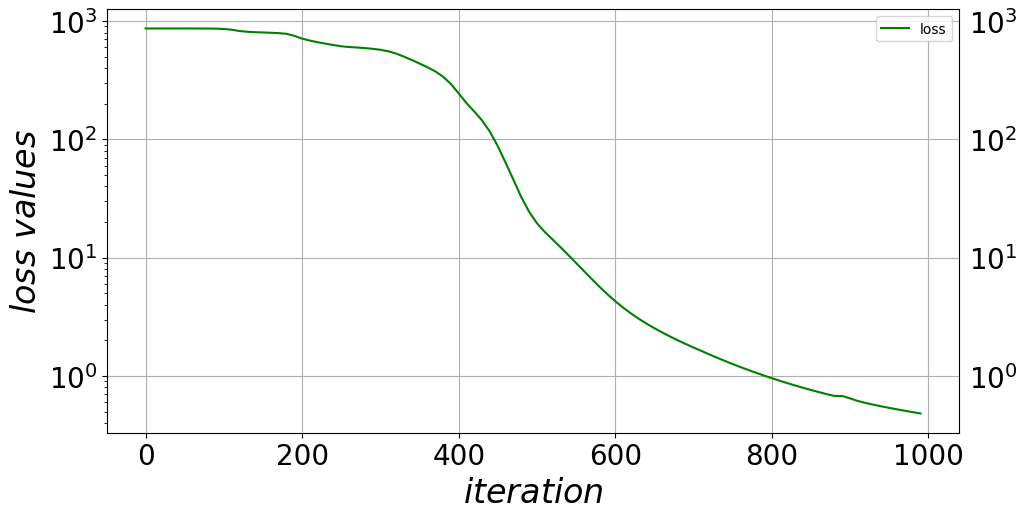

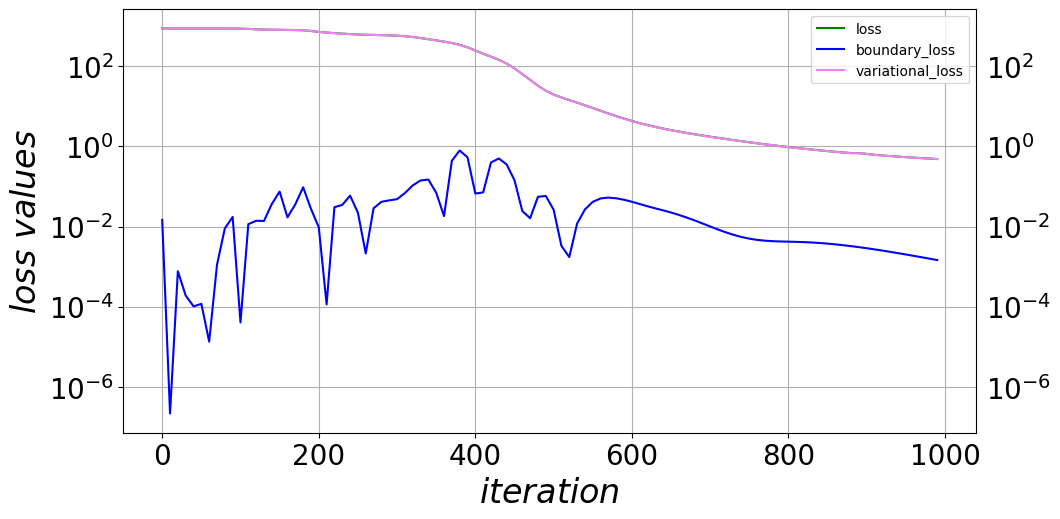

In [14]:
font = 24
#all loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('loss.pdf')
#++++++++++++++++++++++++++++
#partial loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
loss_b  = [total_record[i][2] for i in range(len(total_record))]
loss_v  = [total_record[i][3] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.plot(iteration, loss_b,'blue',label="boundary_loss")
plt.plot(iteration, loss_v, 'violet',label="variational_loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()

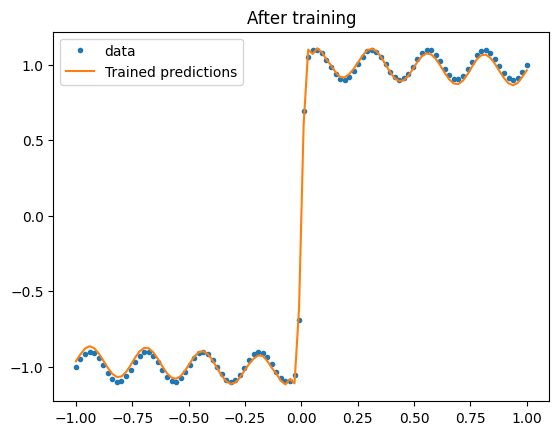

In [13]:
x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float32)
y_test=params.u_exact(x_test)

plt.plot(x_test,y_test, '.', label="data")
plt.plot(x_test, model(x_test), label='Trained predictions')
plt.title('After training')
plt.legend();